<a href="https://www.kaggle.com/nitishraj/spp-boosting-fe-optuna?scriptVersionId=86487898" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><p style="text-align: center;"> <u> Song Popularity Prediction </u>  </p> </h1>
<h3><p style="text-align: center;"> <i> Tabular The Data Is </i>  </p> </h3>

<img src="https://i.gifer.com/9mhx.gif" width="500" />

#### *Yeah, you guessed it right, my favourite musician*

In [66]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,roc_auc_score
from xgboost import XGBClassifier,XGBRegressor,plot_importance,XGBRFRegressor

from scipy.stats import mode,boxcox,skew

import matplotlib.pyplot as plt
import optuna
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer,KNNImputer,IterativeImputer
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier, CatBoostRegressor
from category_encoders import target_encoder
import seaborn as sns
import gc
import sys,os

from scipy.spatial import distance
gc.enable()

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

### 1. Read Train, Test and Submission files

In [2]:
# Read Train, Test and Sample Submission Files
def read_data():
    df_train = pd.read_csv("../input/song-popularity-prediction/train.csv")
    df_test = pd.read_csv("../input/song-popularity-prediction/test.csv")
    df_submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")
    return df_train,df_test,df_submission

In [3]:
# Read datasets
df_train,df_test,df_submission = read_data()

#### Let's see how you look.. any missing values.. ANY?

In [4]:
df_train.isna().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   song_duration_ms  9043 non-null   float64
 2   acousticness      9050 non-null   float64
 3   danceability      9024 non-null   float64
 4   energy            8945 non-null   float64
 5   instrumentalness  9000 non-null   float64
 6   key               9008 non-null   float64
 7   liveness          8994 non-null   float64
 8   loudness          8974 non-null   float64
 9   audio_mode        10000 non-null  int64  
 10  speechiness       10000 non-null  float64
 11  tempo             10000 non-null  float64
 12  time_signature    10000 non-null  int64  
 13  audio_valence     10000 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 1.1 MB


**Insight**: Both Test and Train have same columns which have NULL values .. Nice

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,40000.000,19999.500,11547.150,0.000,9999.750,19999.500,29999.250,39999.000
song_duration_ms,35899.000,193165.848,45822.128,25658.000,166254.500,186660.000,215116.000,491671.000
acousticness,36008.000,0.276,0.298,-0.014,0.040,0.141,0.482,1.065
danceability,35974.000,0.571,0.190,0.044,0.425,0.608,0.718,0.957
energy,36025.000,0.684,0.213,-0.002,0.539,0.704,0.871,1.040
instrumentalness,36015.000,0.037,0.150,-0.004,0.001,0.002,0.003,1.075
key,35935.000,5.043,3.373,0.000,2.000,5.000,8.000,11.000
liveness,35914.000,0.199,0.152,0.028,0.112,0.136,0.213,1.065
loudness,36043.000,-7.408,3.877,-32.118,-9.578,-6.345,-4.621,-0.877
audio_mode,40000.000,0.321,0.467,0.000,0.000,0.000,1.000,1.000


In [8]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.000,4999.500,2886.896,0.000,2499.750,4999.500,7499.250,9999.000
song_duration_ms,9043.000,193091.109,46502.320,25377.000,166689.000,186196.000,215059.000,448558.000
acousticness,9050.000,0.280,0.300,-0.014,0.042,0.142,0.493,1.046
danceability,9024.000,0.570,0.190,0.065,0.427,0.606,0.715,0.947
energy,8945.000,0.684,0.213,0.021,0.542,0.700,0.871,1.031
instrumentalness,9000.000,0.037,0.151,-0.003,0.001,0.002,0.003,1.021
key,9008.000,5.013,3.387,0.000,2.000,5.000,8.000,11.000
liveness,8994.000,0.196,0.149,0.035,0.112,0.136,0.209,1.004
loudness,8974.000,-7.422,3.903,-29.887,-9.655,-6.346,-4.605,-0.879
audio_mode,10000.000,0.324,0.468,0.000,0.000,0.000,1.000,1.000


### What does each variable mean?
> - **Instrumentalness:** This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.
> - **Acousticness:** This value describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
> - **Liveness:** This value describes the probability that the song was recorded with a live audience. According to the official documentation “a value above 0.8 provides strong likelihood that the track is live”.
> - **Speechiness:** “Speechiness detects the presence of spoken words in a track”. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.
> - **Energy:** “(energy) represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy”.
> - **Danceability:** “Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable”.
> - **Valence:** “A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)”
> - **Song Duration ms :** Duration of song in milliseconds
> - **Audio Mode :** No specific description
> - **Tempo :** Tempo (Italian for "time"; plural tempos, or tempi from the Italian plural) is the speed or pace of a given piece.For example, a tempo of 60 beats per minute signifies one beat per second, while a tempo of 120 beats per minute is twice as rapid, signifying one beat every 0.5 seconds
> - **Time Signature :** The time signature indicates how many counts are in each measure and which type of note will receive one count. The top number is commonly 2, 3, 4, or 6.The bottom number is either 4 or 8. Simple time signatures divide music into groups of 2 and compound divide music into groups of 3.
> - **Loudness:** Loudness measures the decibel level of a song. Decibels are relative to a reference value, so songs with lower loudness values are quieter relative to the reference value of 0.
> - **Danceability:** Danceability quantifies how suitable a track is for dancing based on a combination of musical elements, like tempo, rhythm, and beat. Songs with higher danceability have stronger and more regular beats.Like acousticness, danceability is measured on a scale of 0 (low danceability) to 100 (high danceability).

In [9]:
cont_cols = [col for col in df_train.columns if col not in ['id','song_popularity','audio_mode','time_signature','key']]
cat_cols = ['audio_mode','time_signature','key']

In [10]:
print(f'% Distribution of Song Popularity:\n{(df_train.song_popularity.value_counts())/len(df_train.song_popularity)*100}')

% Distribution of Song Popularity:
0   63.560
1   36.440
Name: song_popularity, dtype: float64


In [11]:
df_train.key.value_counts()

0.000     5175
6.000     4949
10.000    4302
2.000     4080
8.000     3028
5.000     2985
9.000     2881
7.000     2690
4.000     2239
1.000     2143
3.000     1346
11.000     117
Name: key, dtype: int64

In [12]:
df_train.audio_mode.value_counts()

0    27154
1    12846
Name: audio_mode, dtype: int64

In [13]:
df_train.time_signature.value_counts()

3    23358
4    15919
2      530
5      193
Name: time_signature, dtype: int64

### 2. Plot the distribution of data for each column

![Alt text](https://media.makeameme.org/created/if-you-didnt-58c83d63de.jpg)

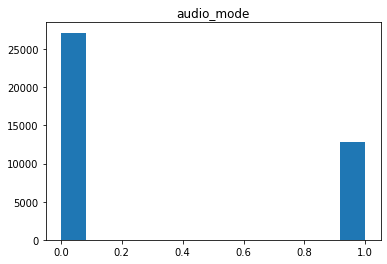

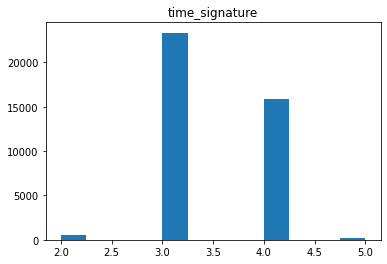

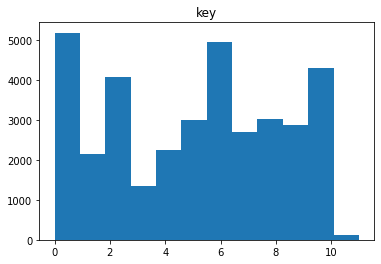

In [14]:
for col in cat_cols:
    df_train.hist(col,grid=False,bins = 12)

> **I NEED SOME CHARTS.. NOW**

Hmm... Below plots will show the distribution of data against our target variables.. Please be nice

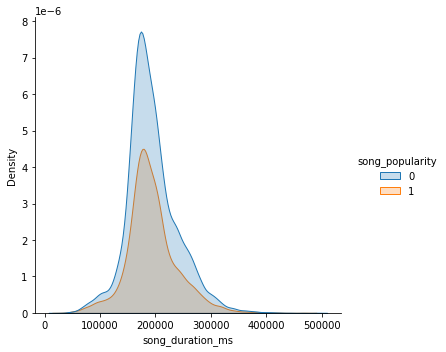

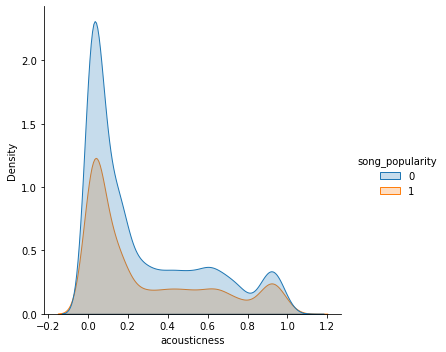

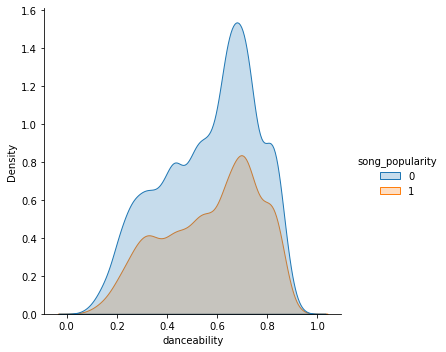

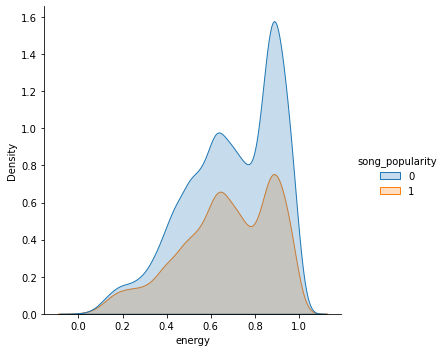

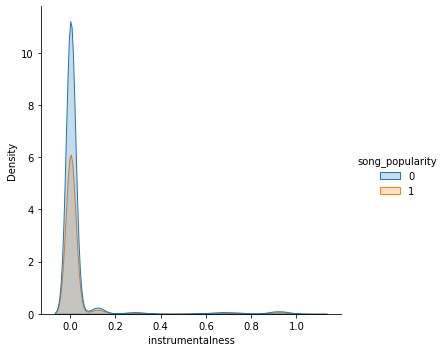

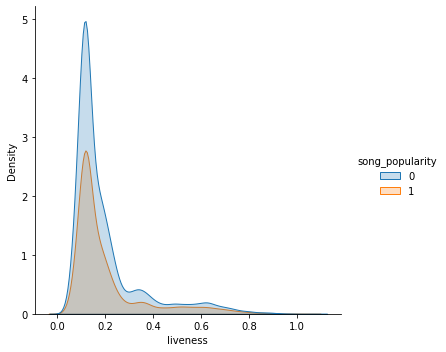

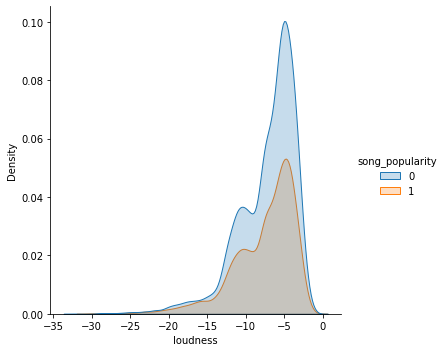

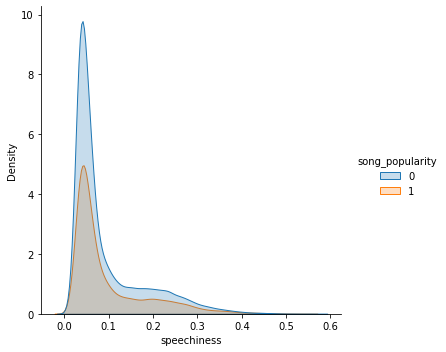

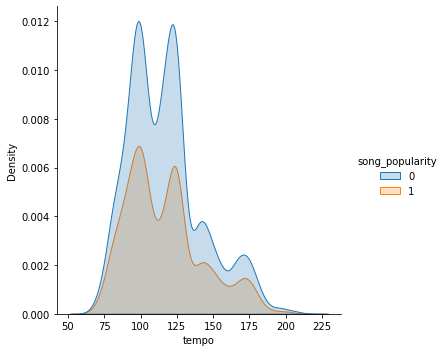

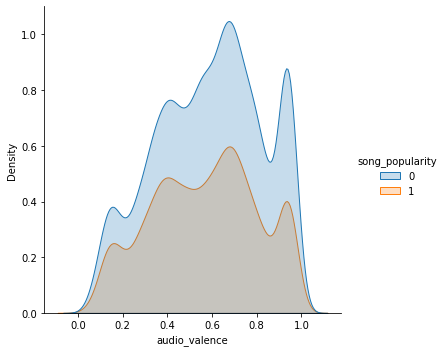

In [15]:
for col in cont_cols:
    sns.displot(data=df_train, x=col,hue="song_popularity",kind = "kde", fill=True)

> Let's check box plots for those.. outliers

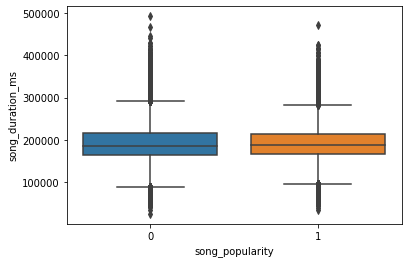

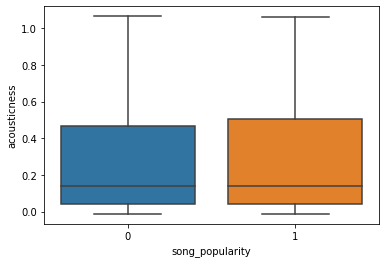

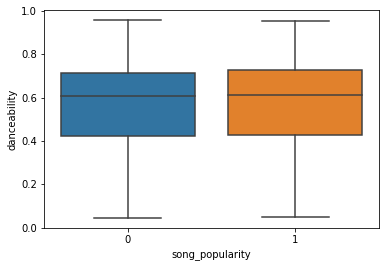

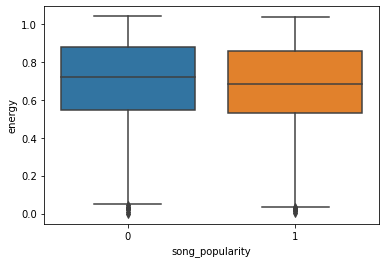

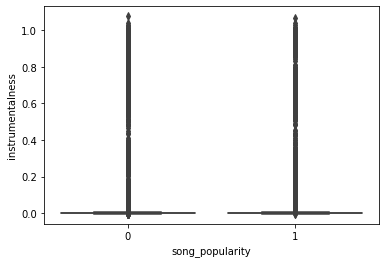

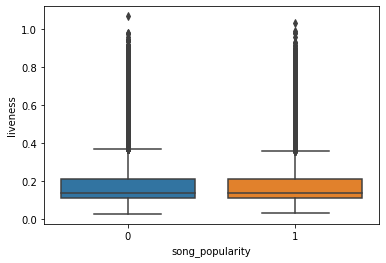

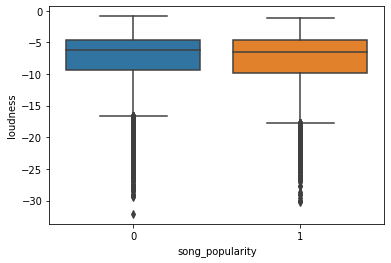

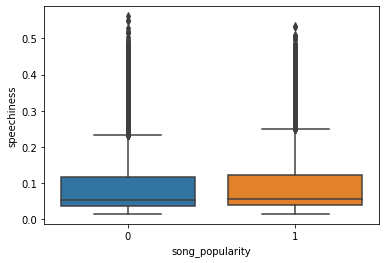

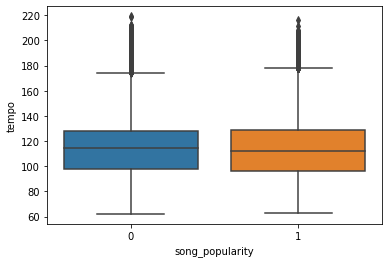

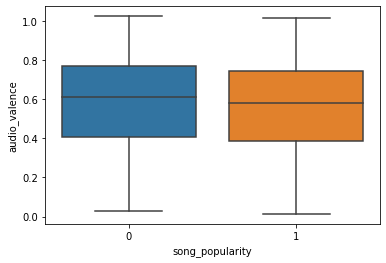

In [16]:
for col in cont_cols:
    plt.figure()
    sns.boxplot(data = df_train,x='song_popularity',y = col)

### I know my visualization skills need a serious upgrade

#### *Working..... On it........*

In [17]:
# Check correlation between the columns
corr = df_train.drop(['id','song_popularity'],axis=1).corr()
cm = sns.light_palette("green", as_cmap=True)
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
corr.style.background_gradient(cmap=cm)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_duration_ms,1.000000,-0.166443,-0.061929,0.148531,-0.024337,0.019354,0.033009,0.152954,-0.017211,-0.001236,0.085490,0.021609,-0.006948
acousticness,-0.166443,1.000000,-0.093737,-0.570177,0.072516,-0.186663,-0.124704,-0.532724,0.066973,-0.130244,-0.190964,-0.205307,-0.250310
danceability,-0.061929,-0.093737,1.000000,0.099933,-0.146447,0.120514,0.045400,0.200148,0.030289,0.177937,-0.089887,0.016455,0.384496
energy,0.148531,-0.570177,0.099933,1.000000,-0.120338,0.210176,0.154907,0.643931,-0.094916,0.120053,0.225465,0.238722,0.324626
instrumentalness,-0.024337,0.072516,-0.146447,-0.120338,1.000000,-0.054726,-0.033445,-0.181889,-0.003617,-0.053209,-0.010350,-0.047397,-0.157760
key,0.019354,-0.186663,0.120514,0.210176,-0.054726,1.000000,0.077046,0.201509,-0.036252,0.102993,0.053206,0.094144,0.132194
liveness,0.033009,-0.124704,0.045400,0.154907,-0.033445,0.077046,1.000000,0.146551,-0.013281,0.076612,0.064425,0.037766,0.084770
loudness,0.152954,-0.532724,0.200148,0.643931,-0.181889,0.201509,0.146551,1.000000,-0.076893,0.157550,0.173979,0.245403,0.356330
audio_mode,-0.017211,0.066973,0.030289,-0.094916,-0.003617,-0.036252,-0.013281,-0.076893,1.000000,0.019790,-0.023202,-0.043714,-0.015683
speechiness,-0.001236,-0.130244,0.177937,0.120053,-0.053209,0.102993,0.076612,0.157550,0.019790,1.000000,0.036192,0.035013,0.112558


> **Let's Create a function below to Scale our data**

In [18]:
# Function to Scale and transform dataset
def data_scaler_fit(option,df):
    if option == 1:
        transformer = StandardScaler().fit(df)
    if option == 2 :
        transformer = RobustScaler().fit(df)
    if option == 3 :
        transformer = MinMaxScaler().fit(df)
    if option == 4 :
        transformer = PowerTransformer(method = 'yeo-johnson').fit(df)
    return transformer

> **A Function to remove outlier, the standard way**

In [19]:
# Function to Remove outliers
def remove_outliers(x,method):
    if method == 'mean':
        upper_limit = x.mean() + (3*x.std())
        lower_limit = x.mean() - (3*x.std())
        return np.where(x > upper_limit,upper_limit,np.where(x <lower_limit,lower_limit,x))
    elif method == 'median':
        upper_limit = x.median() + (1.5*x.quantile(0.75))
        lower_limit = x.median() - (1.5*x.quantile(0.25))
        return np.where(x > upper_limit,upper_limit,np.where(x <lower_limit,lower_limit,x))
    else:
        return x

In [20]:
def imputations(impute_method,method=None):
    if impute_method == 'knn':
        imputer = KNNImputer(n_neighbors = 10,weights = 'distance')
    if impute_method == 'iter':
        imputer = IterativeImputer(max_iter=20)
    if impute_method == 'simple':
        imputer = SimpleImputer(strategy=method)
    if impute_method == 'lgbm':
        if not os.path.exists("kuma_utils/"):
            !git clone https://github.com/analokmaus/kuma_utils.git
        sys.path.append("kuma_utils/")
        from kuma_utils.preprocessing.imputer import LGBMImputer
        imputer = LGBMImputer(n_iter=300, verbose=False)
    return imputer

### 3. Let's Transform those features, one at a time

> 1. Column **Key**,**audio_mode**,**time_signature**  seems to be categorical, hence replacing null values using KNN
> 2. Convert **time_signature** from milliseconds to minutes
> 3. Fill Rest of the columns which has null values using mean of the columns (Might replace with something better)
> 4. Use Boxcox transform to reduce skewness in continuous columns
> 5. Finally using StandarScaler on all continuous columns : *It transforms the data in such a manner that it has mean as 0 and standard deviation as 1*

In [21]:
def feature_transform(df,option,method):
    ids = df.id.values.tolist()
    
    # Replace missing values for continuous columns
    impute = imputations(impute_method)
    
    df_temp = pd.DataFrame(impute.fit_transform(pd.concat([df[cat_cols],df[cont_cols]],axis = 1)))
    
    df_temp.columns = cat_cols + cont_cols
    
    df_cat = df_temp[cat_cols].copy()
    df_cont = df_temp[cont_cols].copy()
    
    # Decreasing data skewness for continuos variables using BoxCox
    df_cont['golden_ratio'] = (df_cont['song_duration_ms'] / 1000) * 0.618033
    df_cont['song_duration_ms'] = boxcox(df_cont.song_duration_ms/60000)[0]
    
    df_cont['instrumentalness_main'] = np.where(df_cont['instrumentalness']<=0.01,df_cont['instrumentalness'],0)
    df_cont['instrumentalness_side'] = np.where(df_cont['instrumentalness']>0.2,df_cont['instrumentalness'],0)
    df_cont.drop('instrumentalness',axis =1 ,inplace=True)
    #df_cont['instrumentalness_side'] = boxcox((df_cont.instrumentalness_side)+0.005)[0]
    #df_cont['instrumentalness_main'] = boxcox((df_cont.instrumentalness_main)+0.2)[0]
    
    
    #df_cont['acousticness'] = boxcox(df_cont.acousticness + 0.2)[0]
    
    df_cont['liveness_main'] = np.where(df_cont['liveness']<0.8,df_cont['liveness'],0)
    df_cont['liveness_side'] = np.where(df_cont['liveness']>=0.8,df_cont['liveness'],0)
    df_cont.drop('liveness',axis =1 ,inplace=True)
    #df_cont['liveness']  = boxcox(df_cont.liveness + 0.04)[0]    
    
    #df_cont['loudness'] = boxcox(df_cont.loudness + 100)[0] 
    #df_cont['energy'] = boxcox(df_cont.energy+0.2)[0]
    #df_cont['danceability'] = boxcox(df_cont.danceability)[0]
  
    
    df_cont['speechiness_sw'] = np.where(df_cont['speechiness']>0.66,df_cont['speechiness'],0)
    df_cont['speechiness_mw'] = np.where((df_cont['speechiness']<=0.66) & (df_cont['speechiness']>=0.33),df_cont['speechiness'],0)
    df_cont['speechiness_m'] = np.where(df_cont['speechiness']<0.33,df_cont['speechiness'],0)
    #df_cont['speechiness'] = boxcox(df_cont.speechiness)[0]
    df_cont.drop('speechiness',axis =1 ,inplace=True)
    
    
    #df_cont['tempo'] = boxcox(df_cont.tempo)[0]
    
    # Normalise Continuous columns
    transformer = data_scaler_fit(option,df_cont)
    df_cont = pd.DataFrame(transformer.transform(df_cont.apply(lambda x: remove_outliers(x,method))))
    
    df_cont.columns = [x for x in cont_cols if (x not in ['instrumentalness','liveness','speechiness'])] + ['golden_ratio','instrumentalness_main','instrumentalness_side','liveness_main','liveness_side','speechiness_sw','speechiness_mw','speechiness_m']
    
    df = pd.concat([df_cont,df_cat.reset_index(drop=True)],axis = 1)
    
    df['id'] = ids
    
    return df

In [22]:
# Initialize Static values
random_state = 151
early_stopping_rounds=1500
verbose = 2000
n_estimators = 15000
n_splits = 5
method = 'mean'
scaling_option = 4
impute_method = 'lgbm'

### 4. Using Optuna for Hyperparameter Tuning

In [31]:
df_train,df_test,df_submission = read_data()

y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


def objective(trial):
    # XGBoost parameters
    
    gc.collect()
    
    final_valid_predictions = {}
    
    scores = []
    auc_score = []
    
    params = {
        "objective": "reg:squaredlogerror",
        "n_estimators": n_estimators,
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.9),
        "subsample": trial.suggest_loguniform("subsample", 0.2, 0.9),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 100.0),
        "lambda": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "gamma": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 100),
        "n_jobs": -1,
        "tree_method": "gpu_hist",
        "predictor" : "gpu_predictor",
    }
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
        xtrain, ytrain = X.iloc[idx_train], y[idx_train]
        xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]

        # Store IDs of validation Dataset
        valid_ids = xvalid.id.values.tolist()

        #Save a copy of yvalid
        true_valid = yvalid

        n_class = len(np.unique(ytrain))

        xtrain = feature_transform(xtrain,scaling_option,method)
        xvalid = feature_transform(xvalid,scaling_option,method)
        
        xtrain = xtrain.drop('id',axis = 1)
        xvalid = xvalid.drop('id',axis = 1)
        
        
        model = XGBRegressor(
            random_state = random_state,
            sampling_method = 'gradient_based',
            use_label_encoder=False,
            eval_metric = ['auc'],
            **params
        )
        model.fit(xtrain, ytrain,early_stopping_rounds=early_stopping_rounds, eval_set=[(xvalid, yvalid)], verbose=verbose)

        preds_valid = model.predict(xvalid)
        
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        auc_scr = roc_auc_score(true_valid, preds_valid)

        auc_score.append(auc_scr)

        print(f"Fold {fold+1} || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    return roc_auc_score(y.to_numpy(), np.array(sorted(final_valid_predictions.items()))[:,1])

In [ ]:
df_train,df_test,df_submission = read_data()

y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


def objective(trial):
    # XGBoost parameters
    
    gc.collect()
    
    final_valid_predictions = {}
    
    scores = []
    auc_score = []
    
    
    "allow_writing_files": False,
    "bagging_temperature": 1,
    "boosting_type": "Plain",
    "border_count": 231,
    "depth": 3,
    "eval_metric": "AUC",
    "l2_leaf_reg": 12,
    "learning_rate": 0.05271928250913923,
    #"loss_function": "Logloss",
    "od_pval": 0.01,
    "od_type": "IncToDec",
    "rsm": 0.22545533368402262,
    "random_seed": 53703,
    "iterations": n_estimators,
    'early_stopping_rounds': early_stopping_rounds ,
    "cat_features" : ['audio_mode','time_signature'],
    
    params = {
        "objective": "reg:squaredlogerror",
        "n_estimators": n_estimators,
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.9),
        "subsample": trial.suggest_loguniform("subsample", 0.2, 0.9),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 100.0),
        "lambda": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "gamma": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 100),
        "n_jobs": -1,
        "tree_method": "gpu_hist",
        "predictor" : "gpu_predictor",
    }
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
        xtrain, ytrain = X.iloc[idx_train], y[idx_train]
        xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]

        # Store IDs of validation Dataset
        valid_ids = xvalid.id.values.tolist()

        #Save a copy of yvalid
        true_valid = yvalid

        n_class = len(np.unique(ytrain))

        xtrain = feature_transform(xtrain,scaling_option,method)
        xvalid = feature_transform(xvalid,scaling_option,method)
        
        xtrain = xtrain.drop('id',axis = 1)
        xvalid = xvalid.drop('id',axis = 1)
        
        
        model = XGBRegressor(
            random_state = random_state,
            sampling_method = 'gradient_based',
            use_label_encoder=False,
            eval_metric = ['auc'],
            **params
        )
        model.fit(xtrain, ytrain,early_stopping_rounds=early_stopping_rounds, eval_set=[(xvalid, yvalid)], verbose=verbose)

        preds_valid = model.predict(xvalid)
        
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        auc_scr = roc_auc_score(true_valid, preds_valid)

        auc_score.append(auc_scr)

        print(f"Fold {fold+1} || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    return roc_auc_score(y.to_numpy(), np.array(sorted(final_valid_predictions.items()))[:,1])

![alt text](https://miro.medium.com/max/900/1*80wf6AeqTLD9ntyFxYMuLw.jpeg)

### Keep Calm .. Optuna is Studying....

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#### Print best parameters ..

In [ ]:
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

### 5. Training XGB Model based on best Parameters

In [ ]:
# Read DATA Again
df_train,df_test,df_submission = read_data()

# Seperate X and y
y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


# Transform Test Dataset
df_test = feature_transform(df_test,scaling_option,method)


final_test_predictions = []
final_valid_predictions = {}

scores = []
auc_score = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
    xtrain, ytrain = X.iloc[idx_train], y[idx_train]
    xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]
    
    xtest = df_test.copy().drop('id',axis = 1)

    # Store IDs of validation Dataset
    valid_ids = xvalid.id.values.tolist()
    
    #Save a copy of yvalid
    true_valid = yvalid
    
    n_class = len(np.unique(ytrain))
    
    xtrain = feature_transform(xtrain,scaling_option,method)
    xvalid = feature_transform(xvalid,scaling_option,method)
    
    xtrain = xtrain.drop('id',axis = 1)
    xvalid = xvalid.drop('id',axis = 1)
    
    
    static = {
        "n_estimators": n_estimators,
        "objective": "reg:squaredlogerror",
        "random_state": random_state,
        "n_jobs": -1,
        #"tree_method": "gpu_hist",
        #"predictor" : "gpu_predictor",
        "eval_metric" : ['aucpr','auc'],
        #"sampling_method" : 'gradient_based',
        "use_label_encoder" : False,
    }
    
    params = dict(static)

    params.update(study.best_params)
    

    model = XGBRegressor(
        **params
    )
    model.fit(xtrain, ytrain,early_stopping_rounds=early_stopping_rounds, eval_set=[(xtrain, ytrain),(xvalid, yvalid)], verbose=verbose)

    preds_valid = model.predict(xvalid)

    test_preds = model.predict(xtest)

    final_test_predictions.append(test_preds)

    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

    auc_scr = roc_auc_score(true_valid, preds_valid)
    
    auc_score.append(auc_scr)
    
    print('_'*65)
    
    print(f"Fold {fold+1}  || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    print('_'*65)
    
    print('\n')
    
    gc.collect()

In [ ]:
#Plot Feature Importance
plt.figure(figsize=(20, 15),dpi=80)
plot_importance(model)
plt.show()

In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
# plot AUCPR
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Valid')
ax.legend()
plt.ylabel('AUCPR Score')
plt.title('XGBoost AUCPR')
plt.show()
# plot AUC
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Valid')
ax.legend()
plt.ylabel('AUC Score')
plt.title('XGBoost AUC')
plt.show()

### 6. Using CAT Boost

In [64]:
hyper_para = {
    "allow_writing_files": False,
    "bagging_temperature": 1,
    "boosting_type": "Plain",
    "border_count": 231,
    "depth": 3,
    "eval_metric": "AUC",
    "l2_leaf_reg": 12,
    "learning_rate": 0.05271928250913923,
    #"loss_function": "Logloss",
    "od_pval": 0.01,
    "od_type": "IncToDec",
    "rsm": 0.22545533368402262,
    "random_seed": 53703,
    "iterations": n_estimators,
    'early_stopping_rounds': early_stopping_rounds ,
    "cat_features" : ['audio_mode','time_signature'],
}

In [67]:
# Read DATA Again
df_train,df_test,df_submission = read_data()

# Seperate X and y
y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


# Transform Test Dataset
df_test = feature_transform(df_test,scaling_option,method)


final_test_predictions = []
final_valid_predictions = {}

scores = []
auc_score = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
    xtrain, ytrain = X.iloc[idx_train], y[idx_train]
    xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]
    
    xtest = df_test.copy().drop('id',axis = 1)

    # Store IDs of validation Dataset
    valid_ids = xvalid.id.values.tolist()
    
    #Save a copy of yvalid
    true_valid = yvalid
    
    n_class = len(np.unique(ytrain))
    
    xtrain = feature_transform(xtrain,scaling_option,method)
    xvalid = feature_transform(xvalid,scaling_option,method)
    
    xtrain = xtrain.drop('id',axis = 1)
    xvalid = xvalid.drop('id',axis = 1)
    
    
    
    params = hyper_para
    

    model = CatBoostRegressor(**params)
    model.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain),(xvalid, yvalid)], verbose=verbose)

    preds_valid = model.predict(xvalid)

    test_preds = model.predict(xtest)

    final_test_predictions.append(test_preds)

    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

    auc_scr = roc_auc_score(true_valid, preds_valid)
    
    auc_score.append(auc_scr)
    
    print('_'*65)
    
    print(f"Fold {fold+1}  || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    print('_'*65)
    
    print('\n')
    
    gc.collect()

0:	test: 0.5225881	test1: 0.5167258	best: 0.5167258 (0)	total: 6.48ms	remaining: 1m 37s
2000:	test: 0.6751946	test1: 0.5757342	best: 0.5789806 (1183)	total: 16.6s	remaining: 1m 48s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.578980589
bestIteration = 1183

Shrink model to first 1184 iterations.
_________________________________________________________________
Fold 1  || AUC : 0.5789805889922771 || Mean AUC : 0.5789805889922771
_________________________________________________________________


0:	test: 0.5220188	test1: 0.5216258	best: 0.5216258 (0)	total: 6.39ms	remaining: 1m 35s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5795926876
bestIteration = 483

Shrink model to first 484 iterations.
_________________________________________________________________
Fold 2  || AUC : 0.5795926876040418 || Mean AUC : 0.5792866382981594
_________________________________________________________________


0:	test: 0.5221321	test1: 0.5048617	best: 0.

### 7. Submit Score

In [68]:
df_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
df_submission.columns = ["id", "song_popularity"]
df_submission.to_csv("submission.csv", index=False)

***Do upvote if you found this useful*** 

PS: I am still working on improving this notebook and Model, so stay tuned!!!

<p style="text-align: center" >
<img src= "https://media.giphy.com/media/DMHEccCwpNxCQBZlvQ/giphy.gif"
</p>